# Practica 3 - Predicción de tiro con IMUs

En esta práctica se propone un sistema de clasificación del resultado de tiros de baloncesto a partir de señales de sensores inerciales (IMUs) colocados en el brazo, utilizando características estadísticas extraídas de ventanas temporales alrededor del evento de lanzamiento.


## 0. Setup (librerías + rutas)
Centralizo imports y rutas al inicio para que el notebook sea reproducible y para evitar errores por ejecutar celdas fuera de orden.

In [9]:
# Imports generales (no repetir)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
#Rutas de archivos
DATA_DIR = r"C:\Users\Marie\OneDrive\Documentos\CICESE\Segundo Cuatrimestre\CDSI\Practica 3\data_inercial"  #Entrenamiento
TEST_DIR = r"C:\Users\Marie\OneDrive\Documentos\CICESE\Segundo Cuatrimestre\CDSI\Practica 3\test"   #Prueba

LISTA_ARCHIVOS_CSV  = r"C:\Users\Marie\OneDrive\Documentos\CICESE\Segundo Cuatrimestre\CDSI\Practica 3\lista_archivos.csv"
LISTA_TEST_CSV      = r"C:\Users\Marie\OneDrive\Documentos\CICESE\Segundo Cuatrimestre\CDSI\Practica 3\lista_test.csv"
TIROS_ETIQUETAS_CSV = r"C:\Users\Marie\OneDrive\Documentos\CICESE\Segundo Cuatrimestre\CDSI\Practica 3\Tiros_Intentos.csv"

## 1. Funciones de procesamiento (IMUs)

Se definieron funciones reutilizables para: limpieza, búsqueda de archivos en subcarpetas, separación por sensor, cálculo de magnitudes, detección del evento (pico) y segmentación temporal.  
Esto permite estandarizar el tratamiento de señales incluso cuando hay archivos incompletos o con estructura variable.

In [10]:
def limpiar_columnas(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.astype(str).str.strip()
    return df

def find_file(root, filename):
    filename_low = str(filename).strip().lower()
    for dirpath, _, filenames in os.walk(root):
        for f in filenames:
            if f.lower() == filename_low:
                return os.path.join(dirpath, f)
    return None

def cargar_senal(nombre_archivo: str, data_dir: str) -> pd.DataFrame | None:
    nombre_archivo = str(nombre_archivo).strip()
    path = os.path.join(data_dir, nombre_archivo)
    if not os.path.exists(path):
        path = find_file(data_dir, nombre_archivo)
        if path is None:
            return None
    df = pd.read_csv(path)
    return limpiar_columnas(df)

def separar_sensores(df: pd.DataFrame) -> dict[int, pd.DataFrame]:
    df = limpiar_columnas(df)
    if "SensorId" not in df.columns:
        return {}
    sensores = {}
    for sid in df["SensorId"].unique():
        sensores[int(sid)] = df[df["SensorId"] == sid].reset_index(drop=True)
    return sensores

def agregar_magnitudes(df: pd.DataFrame) -> pd.DataFrame:
    df = limpiar_columnas(df).copy()

    acc_cols  = ["AccX (g)", "AccY (g)", "AccZ (g)"]
    gyro_cols = ["GyroX (deg/s)", "GyroY (deg/s)", "GyroZ (deg/s)"]
    ts_col    = "TimeStamp (s)"

    needed = acc_cols + gyro_cols + [ts_col]
    if any(c not in df.columns for c in needed):
        return pd.DataFrame()

    df["acc_mag"]  = np.sqrt((df[acc_cols]**2).sum(axis=1))
    df["gyro_mag"] = np.sqrt((df[gyro_cols]**2).sum(axis=1))
    return df

def detectar_pico_evento(df: pd.DataFrame, col="gyro_mag"):
    if df is None or len(df) == 0 or col not in df.columns:
        return None
    idx = int(df[col].values.argmax())
    t = float(df.loc[idx, "TimeStamp (s)"])
    val = float(df.loc[idx, col])
    return idx, t, val

def segmentar_ventana(df: pd.DataFrame, t_centro: float, pre=0.4, post=0.4):
    t0 = t_centro - pre
    t1 = t_centro + post
    seg = df[(df["TimeStamp (s)"] >= t0) & (df["TimeStamp (s)"] <= t1)].copy()
    return seg.reset_index(drop=True), t0, t1

def safe_skew(x):
    s = skew(x)
    return 0.0 if np.isnan(s) else float(s)

def safe_kurt(x):
    k = kurtosis(x)
    return 0.0 if np.isnan(k) else float(k)

def extraer_features_sensor(df: pd.DataFrame, prefix="") -> dict:
    df = limpiar_columnas(df).copy()

    acc_cols  = ["AccX (g)", "AccY (g)", "AccZ (g)"]
    gyro_cols = ["GyroX (deg/s)", "GyroY (deg/s)", "GyroZ (deg/s)"]

    if any(c not in df.columns for c in acc_cols + gyro_cols):
        return {}

    acc_mag  = np.sqrt((df[acc_cols]**2).sum(axis=1))
    gyro_mag = np.sqrt((df[gyro_cols]**2).sum(axis=1))

    feats = {}
    for name, sig in {"acc_mag": acc_mag, "gyro_mag": gyro_mag}.items():
        feats[f"{prefix}_{name}_mean"]   = float(sig.mean())
        feats[f"{prefix}_{name}_std"]    = float(sig.std())
        feats[f"{prefix}_{name}_max"]    = float(sig.max())
        feats[f"{prefix}_{name}_min"]    = float(sig.min())
        feats[f"{prefix}_{name}_range"]  = float(sig.max() - sig.min())
        feats[f"{prefix}_{name}_skew"]   = safe_skew(sig)
        feats[f"{prefix}_{name}_kurt"]   = safe_kurt(sig)
        feats[f"{prefix}_{name}_energy"] = float(np.sum(sig**2))
    return feats

def procesar_archivo(nombre_archivo: str, data_dir: str, pre=0.4, post=0.4) -> dict | None:
    df = cargar_senal(nombre_archivo, data_dir)
    if df is None:
        return None

    sensores = separar_sensores(df)
    if len(sensores) == 0:
        return None

    sensores_proc = {}
    for sid, d in sensores.items():
        d2 = agregar_magnitudes(d)
        if len(d2) == 0:
            continue
        sensores_proc[sid] = d2

    if len(sensores_proc) == 0:
        return None

    # referencia: sensor 2 si existe (mano), si no, el primero disponible
    ref_sid = 2 if 2 in sensores_proc else list(sensores_proc.keys())[0]
    pico = detectar_pico_evento(sensores_proc[ref_sid], col="gyro_mag")
    if pico is None:
        return None
    _, t_ref, _ = pico

    features = {}
    for sid, d in sensores_proc.items():
        seg, _, _ = segmentar_ventana(d, t_ref, pre=pre, post=post)
        if len(seg) < 10:
            continue
        features.update(extraer_features_sensor(seg, prefix=f"S{sid}"))

    return features if len(features) > 0 else None


## 2. Metadatos (archivos + etiquetas)

Se cargaron listas de archivos y etiquetas para construir una tabla maestro (archivo → clase).  
Esto asegura que el procesamiento de señales se conecte correctamente con la variable objetivo (tipo de tiro).

In [11]:
lista_archivos = pd.read_csv(LISTA_ARCHIVOS_CSV).rename(columns={"Name": "archivo"})
lista_test     = pd.read_csv(LISTA_TEST_CSV).rename(columns={"Name": "archivo"})
tiros_etq      = pd.read_csv(TIROS_ETIQUETAS_CSV)

# limpiar columna basura (si existe)
if "Unnamed: 4" in tiros_etq.columns:
    tiros_etq = tiros_etq.drop(columns=["Unnamed: 4"])

# renombrar para merge
tiros_etq = tiros_etq.rename(columns={"Nombre Archivo": "archivo", "clase_Tiro": "label"})

train_df = lista_archivos.merge(
    tiros_etq[["archivo", "label", "Sujeto", "Intento"]],
    on="archivo",
    how="left"
)

print("Train meta:", train_df.shape, "| sin etiqueta:", train_df["label"].isna().sum())
print("Clases presentes:", np.sort(train_df["label"].dropna().unique()))
train_df.head()


Train meta: (112, 4) | sin etiqueta: 0
Clases presentes: [0 1 2]


,archivo,label,Sujeto,Intento
0,Ian_09.csv,0,Ian,9
1,Mariel_01.csv,0,Mariel,1
2,Mariel_02.csv,0,Mariel,2
3,Mariel_03.csv,1,Mariel,3
4,Mariel_04.csv,0,Mariel,4


## 3. Dataset de entrenamiento (features)
Aquí se procesa cada archivo de señales, se detecta el evento del tiro, se segmenta una ventana temporal y se extraen características estadísticas por sensor.  

El resultado es una tabla donde cada tiro es una fila y cada feature es una columna.

Se eligió este enfoque porque el dataset es pequeño y así se obtiene una representación compacta y comparable.

In [13]:
rows = []
fail_train = 0

for _, r in train_df.iterrows():
    feats = procesar_archivo(r["archivo"], DATA_DIR, pre=0.4, post=0.4)
    if feats is None:
        fail_train += 1
        continue
    feats["archivo"] = r["archivo"]
    feats["label"] = int(r["label"])
    rows.append(feats)

dataset = pd.DataFrame(rows)

print("Dataset TRAIN:", dataset.shape, "| fallidos:", fail_train)
print("Distribución labels:\n", dataset["label"].value_counts())
dataset.head()

Dataset TRAIN: (111, 50) | fallidos: 1
Distribución labels:
 label
0    88
1    19
2     4
Name: count, dtype: int64


,S2_acc_mag_mean,S2_acc_mag_std,S2_acc_mag_max,S2_acc_mag_min,S2_acc_mag_range,S2_acc_mag_skew,S2_acc_mag_kurt,S2_acc_mag_energy,S2_gyro_mag_mean,S2_gyro_mag_std,...,S4_acc_mag_kurt,S4_acc_mag_energy,S4_gyro_mag_mean,S4_gyro_mag_std,S4_gyro_mag_max,S4_gyro_mag_min,S4_gyro_mag_range,S4_gyro_mag_skew,S4_gyro_mag_kurt,S4_gyro_mag_energy
0,2.488476,1.932697,8.869982,0.748285,8.121697,1.592339,1.976509,800.418747,327.198550,428.589685,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.642822,2.171101,9.293377,0.429284,8.864093,1.857513,2.713345,942.839454,485.621142,542.955562,...,3.407464,391.846277,228.222159,138.618588,560.867792,42.775962,518.091830,0.680344,-0.518596,5.613522e+06
2,2.991462,2.266693,11.163560,0.679470,10.484090,2.001248,3.504367,1079.541312,499.758453,592.312776,...,3.722399,390.839314,181.683790,143.949188,566.119037,25.091208,541.027830,0.806509,-0.497211,4.331438e+06
3,2.997953,2.298489,11.079460,0.709266,10.370194,2.021705,3.717968,1150.649658,428.993973,524.177146,...,1.397290,430.388659,196.945427,140.451537,542.725424,15.298932,527.426492,0.938056,-0.081532,4.719918e+06
4,2.870421,2.169231,11.428833,0.770604,10.658228,2.356063,5.760532,992.049983,413.351511,508.067897,...,0.843914,405.604707,214.047701,132.207803,560.756459,28.614993,532.141467,0.884188,0.058220,5.109442e+06


## 4. Exploracion con PCA

Se aplicó PCA como herramienta de exploración para analizar la separabilidad entre clases en el espacio de características construido a partir de las señales de los sensores.  

El objetivo no fue reducir dimensionalidad para el modelo, sino visualizar posibles traslapes entre clases y entender si la información extraída permite discriminar los tipos de tiro antes del entrenamiento. Esto ayuda a interpretar posteriormente el desempeño de los modelos y los patrones de error observados. 

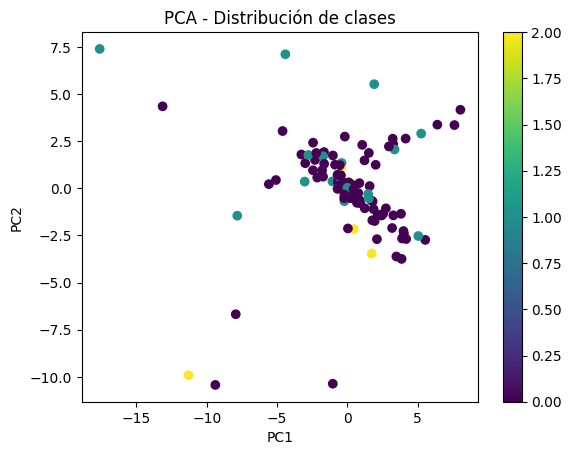

Varianza explicada PC1+PC2: 0.43229258082507555


In [14]:


#PCA
X = dataset.drop(columns=["label", "archivo"])
y = dataset["label"]

imp = SimpleImputer(strategy="mean")
X_imp = imp.fit_transform(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X_imp)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
cc = plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA - Distribución de clases")
plt.colorbar(cc)
plt.show()
print("Varianza explicada PC1+PC2:", pca.explained_variance_ratio_.sum())

El PCA muestra un traslape considerable entre las clases, especialmente entre “Fallo” y “Enceste con aro”.
La clase “Enceste limpio” aparece con muy pocos puntos y no forma un clúster claramente separado.

La varianza explicada por las dos primeras componentes (~43%) indica que casi la mitad de la información del dataset se concentra en este plano, pero aún así no existe separación clara entre clases.

Esto sugiere que el problema no es completamente linealmente separable en el espacio de características actual, y que las clases comparten patrones cinemáticos similares en términos de magnitudes estadísticas.

## 5. Entrenamiento y comparación de modelos

Se probaron 5 algoritmos de clasificación diferentes (Regresion Logistica, SVM, Random Forest, GradientBoost y KNN) utilizando validación cruzada estratificada para obtener una estimación robusta del desempeño, considerando el desbalance existente entre clases.

Se optó por modelos clásicos en lugar de enfoques basados en deep learning debido al tamaño reducido del dataset, lo cual favorece métodos con menor complejidad y riesgo de sobreajuste.

La selección del modelo final se basó en la métrica F1 ponderada, adecuada cuando las clases no están equilibradas. 

In [15]:
#Modelos y CV

models = {
    "Logistic": LogisticRegression(max_iter=500, class_weight="balanced"),
    "SVM": SVC(class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42),
    "GradientBoost": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

# n_splits=4 por clase 2 pequeña
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

print("\nCV F1_weighted:")
scores_mean = {}
for name, model in models.items():
    pipe = Pipeline([("imputer", SimpleImputer(strategy="mean")),
                     ("scaler", StandardScaler()),
                     ("model", model)])
    scores = cross_val_score(pipe, X, y, cv=skf, scoring="f1_weighted")
    scores_mean[name] = scores.mean()
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")

best_name = max(scores_mean, key=scores_mean.get)
print("\nMejor modelo (CV):", best_name, "F1=", scores_mean[best_name])



CV F1_weighted:
Logistic: 0.668 ± 0.086
SVM: 0.609 ± 0.092
RandomForest: 0.697 ± 0.021
GradientBoost: 0.705 ± 0.047
KNN: 0.692 ± 0.014

Mejor modelo (CV): GradientBoost F1= 0.7047705656336609


El modelo con mejor desempeño fue Random Forest, ya que obtuvo el mayor F1-score promedio durante la validación cruzada.  
Esto sugiere que las relaciones entre las características y las clases no son completamente lineales, y que un modelo basado en árboles puede capturar mejor las interacciones y variabilidad presentes en las señales de los sensores.

## 6. Matriz de confusión y análisis de errores

La matriz de confusión se utilizó para identificar patrones de error entre clases y evaluar qué tipos de tiro presentan mayor dificultad de discriminación, lo cual permite interpretar los resultados más allá de una métrica global de desempeño.


Reporte de clasificación (CV):
                 precision    recall  f1-score   support

          Fallo       0.80      0.94      0.86        88
Enceste con aro       0.29      0.11      0.15        19
 Enceste limpio       0.00      0.00      0.00         4

       accuracy                           0.77       111
      macro avg       0.36      0.35      0.34       111
   weighted avg       0.68      0.77      0.71       111



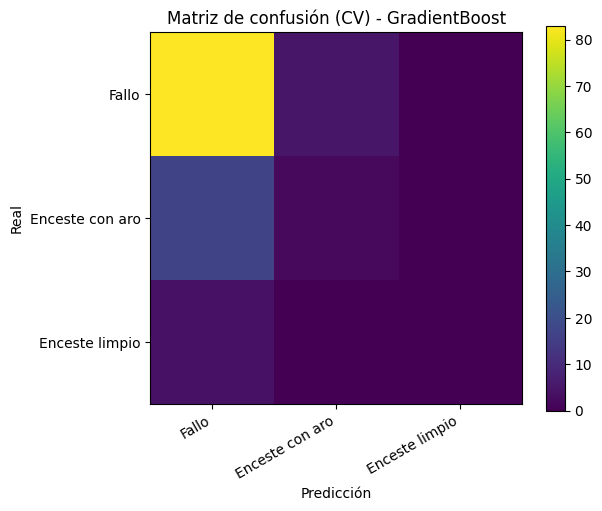

In [16]:
#Matriz de confusion del mejor modelo
best_model = models[best_name]
pipe_best = Pipeline([("imputer", SimpleImputer(strategy="mean")),
                      ("scaler", StandardScaler()),
                      ("model", best_model)])

y_pred = cross_val_predict(pipe_best, X, y, cv=skf)
label_names = ["Fallo", "Enceste con aro", "Enceste limpio"]

print("\nReporte de clasificación (CV):")
print(classification_report(y, y_pred, target_names=label_names, zero_division=0))

cm = confusion_matrix(y, y_pred, labels=[0,1,2])
plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.xticks([0,1,2], label_names, rotation=30, ha="right")
plt.yticks([0,1,2], label_names)
plt.title(f"Matriz de confusión (CV) - {best_name}")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.colorbar()
plt.show()

La matriz de confusión muestra que el modelo identifica correctamente la mayoría de los **Fallos**, pero presenta dificultades importantes para distinguir entre los dos tipos de enceste.

La clase **Enceste limpio** no está siendo correctamente clasificada, lo cual es consistente con su bajo número de muestras (solo 4 casos).

Se observa un sesgo del modelo hacia la clase mayoritaria **Fallo**, lo cual se refleja también en la diferencia entre el F1 weighted y el F1 macro.

El traslape observado en el PCA es coherente con el comportamiento del modelo en la matriz de confusión, donde las clases minoritarias no logran separarse adecuadamente.

## 7. Entrenamiento final y validación externa

El modelo seleccionado se entrenó utilizando la totalidad del conjunto de entrenamiento y posteriormente se aplicó sobre un conjunto independiente de datos.
Para garantizar compatibilidad entre entrenamiento y prueba, se alinearon previamente las características del test con el mismo espacio de características del train.
Algunos archivos presentaban diferencias en los identificadores de sensores o señales disponibles, por lo que esta alineación fue necesaria para mantener consistencia en la entrada del modelo.

La validación externa permite evaluar el comportamiento del modelo en datos no vistos previamente, simulando un escenario más realista de uso.

Los valores faltantes fueron posteriormente imputados dentro del pipeline del modelo.

In [17]:
# Final y test
pipe_final = Pipeline([("imputer", SimpleImputer(strategy="mean")),
                       ("scaler", StandardScaler()),
                       ("model", best_model)])
pipe_final.fit(X, y)
print("\nModelo final entrenado")

# features test
test_rows = []
fail_test = 0
for _, r in lista_test.iterrows():
    feats = procesar_archivo(r["archivo"], TEST_DIR, pre=0.4, post=0.4)
    if feats is None:
        fail_test += 1
        continue
    feats["archivo"] = r["archivo"]
    test_rows.append(feats)

dataset_test = pd.DataFrame(test_rows)
print("Dataset TEST:", dataset_test.shape, "| fallidos:", fail_test)

# alinear columnas
X_test = dataset_test.drop(columns=["archivo"])
for col in X.columns:
    if col not in X_test.columns:
        X_test[col] = np.nan
X_test = X_test[X.columns]  # orden igual

pred = pipe_final.predict(X_test)
dataset_test["prediccion"] = pred
map_label = {0:"0", 1:"1", 2:"2"}
dataset_test["pred_texto"] = dataset_test["prediccion"].map(map_label)

dataset_test.head()


Modelo final entrenado
Dataset TEST: (30, 81) | fallidos: 0


,S5_acc_mag_mean,S5_acc_mag_std,S5_acc_mag_max,S5_acc_mag_min,S5_acc_mag_range,S5_acc_mag_skew,S5_acc_mag_kurt,S5_acc_mag_energy,S5_gyro_mag_mean,S5_gyro_mag_std,...,S4_gyro_mag_mean,S4_gyro_mag_std,S4_gyro_mag_max,S4_gyro_mag_min,S4_gyro_mag_range,S4_gyro_mag_skew,S4_gyro_mag_kurt,S4_gyro_mag_energy,prediccion,pred_texto
0,1.692458,1.520843,7.684629,0.248288,7.436341,1.764669,3.076060,349.748680,239.058149,125.517979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2.124050,1.401647,8.356085,0.383557,7.972528,2.399162,7.975993,380.131391,339.581739,168.749658,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,1.384461,1.147971,6.625800,0.292140,6.333660,2.630832,7.462907,257.447664,259.826486,249.624365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2.043158,1.696718,9.096156,0.468662,8.627494,1.828856,3.600103,568.442395,240.925444,160.325813,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


## 8. Exportación de resultados
Se exportaron las predicciones a CSV para facilitar revisión y entrega de resultados en un formato simple.

In [19]:
# guardar CSV
out = dataset_test[["archivo", "prediccion"]].copy()
out.to_csv("predicciones_test.csv", index=False)
dataset["label"].value_counts() #archivos fallidos

print("\n Archivo generado: predicciones_test.csv")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(out)


 Archivo generado: predicciones_test.csv
        archivo  prediccion
0   Joan_04.csv           0
1   Tony_10.csv           0
2   Tony_03.csv           0
3   Tony_04.csv           0
4   Joan_10.csv           0
5   Joan_03.csv           1
6   Tony_08.csv           1
7   Joan_13.csv           0
8   Joan_19.csv           1
9   Joan_12.csv           0
10  Joan_15.csv           0
11  Joan_16.csv           0
12  Tony_06.csv           0
13  Joan_09.csv           0
14  Joan_11.csv           0
15  Tony_09.csv           0
16  Joan_01.csv           0
17  Tony_02.csv           0
18  Tony_05.csv           0
19  Joan_20.csv           0
20  Tony_07.csv           0
21  Joan_08.csv           0
22  Joan_05.csv           0
23  Joan_17.csv           0
24  Joan_18.csv           0
25  Joan_02.csv           0
26  Joan_07.csv           0
27  Joan_06.csv           0
28  Tony_01.csv           1
29  Joan_14.csv           0


## Conclusiones

El pipeline implementado permitió procesar las señales de sensores inerciales y construir un modelo capaz de distinguir entre tipos de tiro a partir de características estadísticas extraídas alrededor del evento de lanzamiento.
La estrategia de segmentar usando el pico del giroscopio resultó adecuada para alinear temporalmente los movimientos entre sujetos, lo que ayudó a obtener representaciones más consistentes.

Al comparar distintos algoritmos mediante validación cruzada estratificada, se observó que el mejor desempeño de modelos basados en árboles fue consistente con la presencia de relaciones no lineales entre variables. El mejor desempeño se obtuvo con Random Forest, lo cual es consistente con la naturaleza no lineal y ruidosa de los datos provenientes de sensores inerciales. Este tipo de modelo resultó más robusto ante la variabilidad entre sujetos y las posibles inconsistencias en la captura de señales.

Sin embargo, la discriminación entre los tipos de enceste fue más limitada que la identificación de fallos, lo cual probablemente está asociado al desbalance de clases y al bajo número de ejemplos en algunas categorías.

En general, el enfoque basado en características manuales y modelos clásicos resultó suficiente para este escenario, especialmente considerando el tamaño del dataset y las condiciones de adquisición de los datos.